<h1 align = "center"> Community Analysis </h1>

---

This section will go through the community analysis in this project. This section includes a description of how the communities were detected and exploratory analysis of these. The exploratory analysis are going to focus on three of the character attributes namely allegiance, religion and culture, as these appears to be the most important. Next we are going to perform text analysis which will include computation of TF-IDF which is presented in wordclouds. Lastly, are we going to look at the community sentiment. 

Before starting on the analysis are we going to import the needed packages. 

In [1]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd 
import numpy as np 
import networkx as nx
import matplotlib.pyplot as plt 
import urllib
import json
import re 
import os 
from imdb import IMDb
import contextlib
import powerlaw

from fa2 import ForceAtlas2
import powerlaw
from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import requests

import nltk
from nltk import FreqDist
from nltk.text import TextCollection
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from community import community_louvain
import plotly.express as px

from itertools import groupby
#Download NLTK stuff for lemmatizer and tokenizer:
nltk.download('punkt')
nltk.download('wordnet')


#Set stuff for nice formmatting of plots: 
import seaborn as sns
sns.set()
%matplotlib inline
import itertools
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
import string
import warnings

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<h1 align = "center" > 1. Community detection and exploratory analysis </h1>

---

This section will start by detecting the communities in the Game Of Thrones network across all seasons, and how the network is generated can be seen in section 2.1.1 in the Explainer Notebook. Afterwards, are we going to investigate the communities. We will start out by reading the network file which is saved in a `gpickle` file. 

In [2]:
base_path = "../data/"
G = nx.read_gpickle(base_path+"got_G.gpickle")

<h2 align = "center"> 1.1 How the communities are detected </h2>

We are going to detect communities based on the Louvain algorithm. 
The Louvain algorithm works in a two phased manner which is a modularity optimization phase and a community aggregation phase.
Starting out with the modularity optimization here every node has its own community, afterwards it is estimated what the potential change in modularity is if the node is moved in two the neighbouring communities. The node is then moved two the community which has the highest increase ie. improvement of modularity. The node is staying in the community if the modularity does not improve. 

After optimizing the modularity it is time for phase two where the community aggregation begin. Here all nodes assigned to the same community are merged to one node. Inter-community edges are turned into selfloop, and the selfloop is weighted by the number of edges in the given community. 

The phases are repeated in a iterative manner until the network achieve no further improvement in modularity. 

As the algorithm needs a undirected network we are going to convert our directed network to a undirected using the built-in function `to_undirected`. 

Afterwards we order our communities in a dictionary, where the keys are the character names and the values are the character names. This will make the investigation of the communities more easy later on.

In [3]:
#Generate partitioning into communities using louvain method:
G_unDi = G.to_undirected()
partition = community_louvain.best_partition(G_unDi, randomize=False)

#Create a dict containing the communities and the characters in the community:
link_partition = {c: [character for character, community in partition.items() if community == c] 
                    for c in set(partition.values())}

Having generated the network are we going to investigate some basics stats of these communities namely how many communities have we detected and what is the modularity of this partitioning.

In [4]:
print(f'Number of communities in network: {len(link_partition)}')
print(f'Modularity of partition: {round(community_louvain.modularity(partition,G_unDi),3)}')

Number of communities in network: 6
Modularity of partition: 0.319


The Louvain algorithm has detected 6 communities, and this partitioning have a modularity of 0.319 which indicates that the partitioning clearly contains sub-groups which the algorithm have detected. 

Having determined that the split is decent and we have 6 communities we are going to look at the size of each community. 

In [5]:
dict_list = {}
#Save the community sizes
dict_list["Number of members in community"] = [len(com) for com in link_partition.values()]
#Save community number
dict_list["Community"] = list(link_partition.keys())

#Convert to dataframe for easy plotting
df = pd.DataFrame(dict_list)
#Show plot
fig = px.bar(df, x="Community",y  ='Number of members in community', title = "Distribution plot of community sizes")
fig.show()

Clearly community 0 is the smallest with only 13 characters whereas community 1 is the largest community with 43 characters. Community 2-5 is quite similar in their sizes and contain in the range of 25-29 characters. When thinking of the largest group of people community 1 could come from the group of characters living in Kings Landing. 

<h2 align = "center"> 1.2 Exploratory analysis of communities </h2>

Having determined community sizes, we are going to dig a little deeper into each community and its characteristics, namely how does the distribution of religions, allegiances and cultures look inside each community. This could help us decode which characters are present and how the community has been created. This could point us in the right direction of what is the underlying pattern. 

In [6]:
attributes_dict, dfs, figs = {},{},{}

#Selected attributes
attributes = ["religion", "appearances", "culture", "allegiance"]

#Iterate through the selected attributes:
for attribute in attributes: 

    #Get all attributes from the network
    attributes_dict[attribute] = nx.get_node_attributes(G, attribute)
    
    com_dict  = {}
    att,counter,com_ = [], [],[]

    #Iterate through all communities
    for com, char_list in link_partition.items():        
        #Extract the attribute values for each character:
        tmp = [attributes_dict[attribute][char] for char in char_list]

        #Extract count of categories for each attribute
        tmp2 = [[tmp.count(att),att]for att in set(tmp) if att != ""]#

        #Parse empty strings to unknown
        for l1 in tmp2:
            if l1[1] == "":
                l1[1] = "Uknown"
            att.append(l1[1])
            counter.append(l1[0])

        com_.extend([com]*len(tmp2))
    #Generate dataframe and remove nans       
    dfs[attribute.capitalize()] = pd.DataFrame({"Community" : com_,
                                                attribute.capitalize() : att,
                                                "Count" : counter}).fillna(0)
    #Create figure and save in dict:
    figs[attribute.capitalize()] = px.bar(dfs[attribute.capitalize()], 
                                            x="Community", y="Count", color=attribute.capitalize(), title="{} distribution in communities".format(attribute.capitalize()),
                                            width = 900, height = 375)

We have now generated the figures for each of the selected attributes and saved them in a dictionary so we can visualize them one-by-one and trying to understand the pattern. 

In [7]:
figs['Religion'].show()

From the above we can notice that *Community 0* contains equal parts of characters being part of Faith of the Seven religion and Drowned God, whereas *Community 1* mainly contain characters being part of Faith of the Seven. 

*Community 0* could therefore be expected to contain people from the Iron Island and as well from Kings Landing, whereas *Community 1* contains primarily people from Faith of the Seven, and 1 from the Old Gods of the Forest, this could maybe be people being from House Lannister and Sansa Stark as these characters are very well connected in large parts of the story. 

Next, in *Community 2* the religions are a mix of the Great Stallion, the Old Gods of the Forest, the Faith of the Seven and Ghiscari. This could be due to the characters surrounding Daenarys Targaryen, as her group are a rather mixed group. 

The next three communities are also rather mixed, and could represent multiple groups of characters thus being rather complicated to decrypt. 

In [8]:
figs['Allegiance'].show()

From the figure above it can be seen that the communities are very mixed when it comes to allegiance, which would be expected as the Game Of Thrones universe contains a lot of different allegiances, and these are mixing up together. Eg. the people from the North are part of many different allegiances, but are grouping together when needed for eg. war. 

One could see that the largest allegiance in community 1 are House Lannister, but also contains Petyr Baelish, Kingsguard, Sparrows, House Clegane etc. This community appears to describe the important people of Kings Landing. 

Community 2 is described by House Targaryen, Second Sons, Unsullied, Drogo and could describe the group sorounding Daenarys Targaryen.

Community 3 is described by House Umber, Free Folk, Night's Watch and White Walkers, maybe this community describes the people interacting at the Wall and the land around it. This could explain this group of allegiances. 

In [9]:
figs['Culture'].show()


Lastly, we are looking into what culture each community contains. Here it can be seen that the Andals are the largest in Community 1, 3, and 5. This would be expected as this is the largeset cultural group in Game Of Thrones. 

Community 2 contains large group of Dothraki people, and this again underlines that community 2 could be the group of characters surrounding Daenarys. 

Similarly, we see that community 3 contains Free Folk, Northmen, White Walkers, Children of the Forest, which could indicate the people at the Wall and beyond. 

<h1 align = "center"> 2. Network analysis of communities </h1>

---

This section is devoted to investigate the each of the community networks, which is going to be presented in an interactive visualization like the one in the *Network Analysis* notebook visualizing the network of each season and across them all. This app have the same fucntionalities.

We are going to look a little deeper into what each community contain namely what characters, as we have already looked into the distribution of the character attributes. 

<h2 align = "center"> 2.1 How is the app created  </h2>

The app has the same setup as the app described in *Network Analysis*, where the node size and the `alpha` value ie. how transparent each node is depends on its degree. Further, the `edge` width depends on the frequency of the link between the two given nodes. The positions of the nodes are determined by the `ForceAtlas2` algorith and the specific settings can be seen [here](https://github.com/MikkelMathiasen23/GameOfThrones_Community/blob/main/data_methods.py). 

The functionality of the app are the same where the user have four sections in the bottom. To the left it is possible to select the community one wants to investigate. Just to the right one can select the overlay namely religion, culture and allegiance, which changes the colour of the nodes. 

If one selects a node by clicking on it, further information of the selected node will appear in the *Click data* section, and the image of the selected character in *Character image* section. 

The app is hosted on a separate Github as Heroku only allows for one app pr. repository. The app uses as input the full network `gpickle` file and as well the link partitioning dictionary which generate above. By selecting a community the characters from the original network is extract with all the information ie. attributes and etc. which then are displayed below. 

The app contains two separate python files, one for processing the data which can be found [here](https://github.com/MikkelMathiasen23/GameOfThrones_Community/blob/main/data_methods.py) and one for generation of the app which can be found [here](https://github.com/MikkelMathiasen23/GameOfThrones_Community/blob/main/network_app.py). The repository containing all the data and files for the app generation can be found [here](https://github.com/MikkelMathiasen23/GameOfThrones_Community).

<iframe src="https://gameofthronescommunity.herokuapp.com/" width ="1000" height = "1200"> </iframe>

<h2 align = "center"> 2.2 Insights  </h2>

We are now going to extract some insights from the app which were described above, and trying to understand which characters are present in each community. 

**Community 0:**
Lets start with community 0. This community is mostly based on characters from the Sand family, Martell and Greyjoy and last Myrcella Baratheon. Where it appears that Ellaria Sand is the key person. First of all the Martell and Sand famiilies are strongly connected as Oberyn and Ellaria is married, further the plan is that Myrcella Baratheon should be married with Trystane Martell. And clearly, Ellaria is playing a key role in all these interactions after Oberyn are killed by Gregor Clegane. 

**Community 1:**
This community clearly have all the characters acting in King's Landing this includes Paetyr Baelish, Sansa Stark, Cersei Lannister, Tyrion Lannister, Shagga, Shay and Meryn Trant just to name a few. Which all acts here, Shagga comes to King's Landing with Tyrion Lannister with the promise of getting the River Lands. Clearly, Cersei, Sansa, Tyrion and Petyr plays a large role in this community as these are a big part of the story and interacts with tons of other characters.

**Community 2:**
This community is clearly generated based on the characters sorounding Daenerys Targaryen which also are key element in this community which can seen from the app. Further, Jorah Mormont are a key player and also linking her with some of the people of Westeros. To name a few characters sorounding her is Drogo, Viserys and Robert Baratheon. Drogo is her husband until he dies, but still have a large impact on her story moving forward as she gets her dragons while being married with him. Viserys is her brother, and are "travelling" with her in the first season. Robert tries to get her murdered as the Targaryen family are attempted to eradicate. 


**Community 3:**
Community 3 clearly has Jon Snow in focus, and the people sorounding him and to name just a few: Samwell Tarly, Gilly, Ygritte, Mance Raider and Maester Aemon. Samwell becomes one of Jons best friends while being part of the Night's Watch, and he finds Gilly which we also can see they are very well connected. Further, when Jon becomes friends with the wild Mance and Ygritte become important characters for Jon Snow. Aemon are Maester in the Night's watch and are an important person for both Samwell and Jon which we also can see from the network.


**Community 4:**
Robb Stark is the main character in this community. He is impacted by the people involved in the war and his story including Bolton family, his mother Catelyn Stark and Walder Frey.


**Community 5:**
This community clearly has Arya Stark in center, and people impacting her story. This includes Jaqen H'ghar, Gendry Baratheon, Hot Pie and Sandor Clegane. Jaqen is the man with many faces learning Arya how to fight in the end after making her blind. Gendry travels with Arya when leaving King's Landing after Ned Stark are killed. Sandor Clegane assists Arya multiple times. Further we can see that Gendry are connected with a little group sorounding Davos. 

<h1 align = "center"> 3. Text analysis of communities </h1>

---

Having determined the properties of the communities and which character there are present we are next diving into text analysis of the communities. The text analysis consist of computing TF-IDF for each community, which generally have the samme approach as in the *Text Analysis* Notebook. 

Before starting on this we are going to define a function for the final cleaning of the text. 

The text used for the text analysis in this part is based on the wiki-pages of each character. 




In [10]:
def clean_text(txt, charlist):    
    """
    Function for cleaning the text. As input it takes the text that needs cleaning and 
    a character list of which character name that should be removed.

    The function tokenize, remove stopwords, lemmatize and turn the text into lower case.
    """
    #Convert text to lower case
    txt = txt.lower()
    #Tokenize:
    word_tokens = wordpunct_tokenize(txt)
    #Remove stopwords    
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]

    #Lemmatize text 
    wnlet = WordNetLemmatizer()
    words = [wnlet.lemmatize(w) for w in filtered_sentence] 
    return words

We now need to create a list of character names including full name, first name and last name which we wan't to remove from the text. We append the names to the list of stopwords. 

In [11]:
#Character list
char_list = [f.split('.txt')[0] for f in os.listdir(base_path +"got_cleaned/")]

char_names = []
for char in char_list:
    #Turn name to lower
    char = char.lower()
    #Get full name
    char_names.append(char.replace("_"," "))
    #Get first and last name
    char_names.extend(char.split('_'))
#Get all stopwords
stop_words = set(stopwords.words('english') + list(string.punctuation) + list(char_names))

First we are going to extract all the text needed for the text analysis. The text can be found [here](), where we are going to load all text files for all characters and save them in a dictionary. The dictionary keys are the character names and the values are the cleaned text using the clean function described above. 

In [12]:
char_pages = {}
#Get all characters:
characters = [f.split('.txt')[0] for f in os.listdir(base_path+"got_cleaned/")]

#Iterate through all characters
for char in characters:
    #Replace _ with space
    name = char.replace('_', ' ')
    #Load text 
    with open(base_path+'got_cleaned/'+char+".txt", "r", encoding = 'utf-8') as text_file:
            txt = text_file.readlines()
    #Clean text and save in dict
    char_pages[name] = clean_text(" ".join(txt),characters)

As we have loaded the data in a dictionary for each character it is now easy to compute the TC for each community, as we can just iterate through each community and the characters in the given community. When iterating through the characters in the community we just append the text for the selected community. To compute the frequencies of the words use the `FreqDist` function form the `nltk` library.

In [13]:
l_dict_com, tc_dict_com = {}, {}
for com, characters in link_partition.items():
    words = []
    for char in characters:
        try:
            words.extend(char_pages[char.replace("_", " ")])
        except:
            continue
    
    l_dict_com[com] = len(words)
    #Compute TC for the community words:
    tc_dict_com[com] = FreqDist(words)

The TC are computed and saved in a dictionary where the keys are the community number and the values are the frequencies of the words in the given community. 

We are now ready to compute the next part of the TC-IDF score namely the IDF. We have all the unique words across all communities in the TC-dictionary and we therefore extract all unique words from this utilizing the `set` functionality in python which only save unique values. The last component before we can compute the IDF are the number of documents, which is the number of communities ie. 6. We are now ready to compute the IDF in same manner as described in the *Text Analysis* Explainer Notebook. 

In [14]:
# Find all unique words
unique_words = set(list(itertools.chain(*tc_dict_com.values())))

# Calculate idf
idf_com = {word: 
            #Find in how many documents that each word is present:
            np.log(len(link_partition.keys()) / sum([tf[word] > 0 for k, tf in tc_dict_com.items()])) 
            #Iterate through unique words:
            for word in unique_words
      }

We have now a dictionary with the IDF values of all words saved in a dictionary with keys being the words and the values the IDF value of the given word. We are now just left with the task of computing the TF-IDF score which can easily be computed by iterating through all the communities and then the words in the given community. This is done below. 

In [15]:
#Create dict for tf-idf values:
tf_idf_com = {}

#Iterate through communities:
for com in link_partition.keys():
    tf_idf = {}
    #Iterate through each word in each community:
    for word, tf_value in tc_dict_com[com].items():
        #Extract IDF
        idf_value = idf_com[word]
        #Compute TF-IDF
        tf_idf[word] = idf_value*tf_value/l_dict_com[com]
    tf_idf_com[com] = tf_idf   

The TF-IDF values are now ready for all words in each community. We are going to visualize this using a plot function and by the use of the `WordCloud` function. The function for plotting can be seen below. 

In [16]:
def plot_wordcloud(communities,tc_idf_com, name=None):
    """
    Function for plotting the wordclouds of a TC-IDF dict.

    
    """
    #Setup figure
    plt.figure(figsize = (12,15))
    #Iterate through communities:
    for i,com in enumerate(communities):
        word_list= []
        #Get all words for the community
        for word, value in tc_idf_com[com].items():
            word_list.append((word+' ')*int(np.ceil(value)))
        #Make list of words to string
        word_list = " ".join(word_list)
        #Generate wordcloud
        wc = WordCloud(collocations=False).generate(word_list)

        #Plotting
        plt.subplot(3,2,i+1)
        plt.imshow(wc, interpolation='bilinear')
        if name is not None:
            com = name[i]
        plt.title(com, fontsize = 40)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

We are now ready to visualize our text analysis in the wordclouds which are presented in the figure below. 

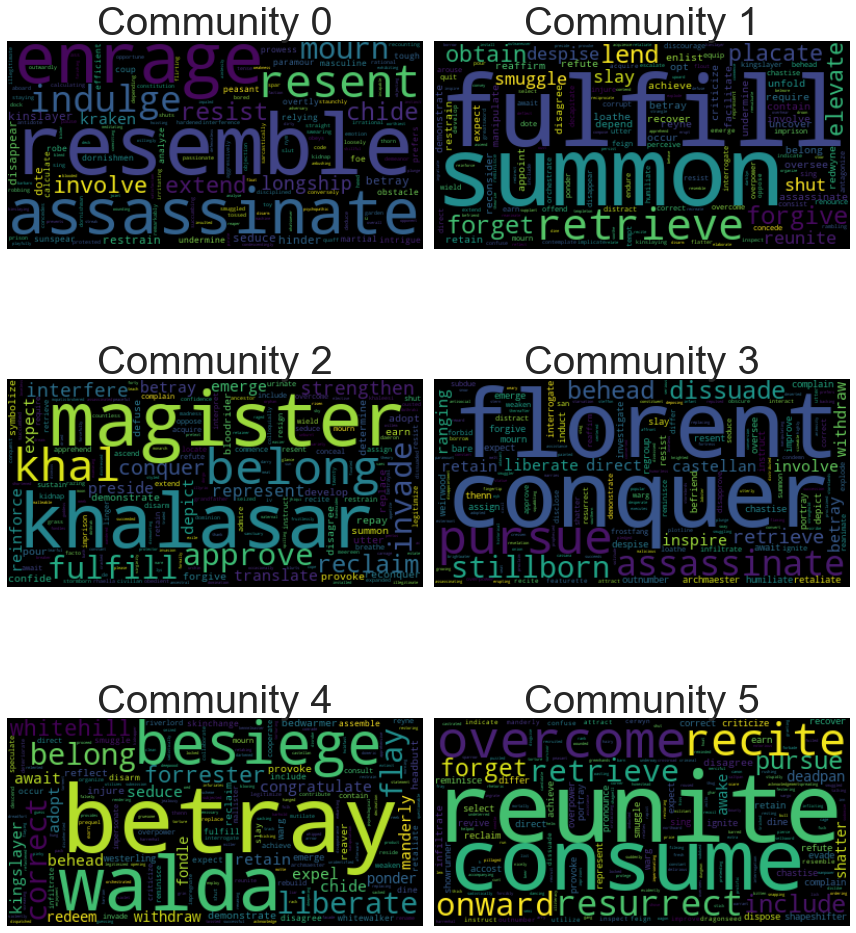

In [17]:
selected_com = [0,1,2,3,4,5]
#Change community name
names = ["Community " + str(com) for com in selected_com]
#Plot communities
plot_wordcloud(selected_com, tf_idf_com, names )

We notice that the words are very descriptive. If we use community 2 as an example we can see that these words match very well with the expectation that this group describes the people around Daenerys Targaryen. This includes khal, khalasar, invade, conquer and reclaim as she starts out with being wife of Khal Drogo and being part of his khalasar. Later she invades multiple cities and conquer a large part of the Game Of Thrones universe. Further she tries to reclaim the Iron Throne. 

The same pattern of words describing the community can be seen in the other wordclouds. 

<h1 align = "center"> 4. Sentiment analysis </h1>

---

This part will dive into the sentiment of each community, this will be based on character dialogoues instead of the wiki-pages as used in the previous part. This is done as it is expected that the dialogoue of each character better resembles the character's mood rather than a wiki-page describing the character. 

The principles behind LabMT and VADER are described in the *Text Analysis* Explainer Notebook. 

We will start out by loading the LabMT data, and convert this into a dictionary where we have the word as key and the happiness score as value. 

In [18]:
LabMT = pd.read_table(base_path+'labMIT-1.0.txt', delimiter="\t")
#Convert LabMT to a dictionary:
LabMT_dict = {word : happiness_score for word,happiness_score in zip(LabMT['word'], LabMT['happiness_average']) }

Next, we load the VADER sentiment analyzer using the built-in function `SentimentIntensityAnalyzer` and lemmatizer.  

In [19]:
#Load VADER wordlist:
analyzer = SentimentIntensityAnalyzer()
lemmatizer = WordNetLemmatizer() 

We now define two functions for computing the LabMT and VADER sentiment scores of a list of tokens. Where these returns the mean of the sentiment of the tokens it takes as input. 

In [20]:
#Functions to compute LabMT and VADER sentiment values of tokens:
def sentiment_LabMT(tokens):
    #Extract tokens that are present in LabMT:
    tokens_LabMT = [token for token in tokens if token in LabMT_dict.keys()]
    #Extract sentiment values of tokens:
    happiness_LabMT = [LabMT_dict[token] for token in tokens_LabMT]

    #Return mean values of sentiments:
    return  np.mean(happiness_LabMT)

def sentiment_VADER(tokens):
    
    happiness_VADER = [analyzer.polarity_scores(sentence)['compound'] for sentence in tokens]
    return np.mean(happiness_VADER)

The data are now loaded from Github in `json` format, where we are going to save it in a new format. Here we are going to save it in a character dictionary, where the keys are the character name and values are the character dialogoue. 

In [21]:
### GET DIAGLOGUE FOR EACH CHARACTER:
resp = requests.get("https://raw.githubusercontent.com/jeffreylancaster/game-of-thrones/master/data/script-bag-of-words.json")
diag = json.loads(resp.text)

char_diag = {}

for element in diag:
    episode = element['episodeNum']
    season = element['seasonNum']
    title = element['episodeTitle']
    text = element['text']
    #Iterate through all dialogoue for the episode:
    for textObj in text:

        #Save the dialogoue for the character 
        if textObj['name'] in char_diag:
            char_diag[textObj['name']].append(textObj['text'])
        else:
            char_diag[textObj['name']] = [textObj['text']]

As this data contain more characters than we have in our network we are going to create a list with all the characters that we have in our character network.

In [22]:
#Get files in directory:
files = os.listdir(base_path+"got/")
#Get character names:
char_list = [file.split('.txt')[0] for file in files]

As VADER does not expect any preprocessing of the text we are just going to give the raw text. The LabMT methods expects the text have been preprocessed. We are therefore going to tokenize and lemmatize the text and convert into lower case. 

In [23]:
#Create tokens for the two methods
tokens_LabMT = {char : [lemmatizer.lemmatize(word) for word in word_tokenize(" ".join(text).lower())] for char, text in char_diag.items()}
tokens_VADER = char_diag    

Now we have the tokens ready for the two sentiment functions defined above, and we therefore compute the sentiment for all characters that are present in our network. This is done below:

In [24]:
#Suprress warnings:
warnings.filterwarnings("ignore")
#Compute sentiment for each character:
char_sentiment_LabMT = {char :sentiment_LabMT(tokens_values) for char, tokens_values in tokens_LabMT.items() if char.replace(" ", "_") in char_list}
char_sentiment_VADER = {char :sentiment_VADER(tokens_values) for char, tokens_values in tokens_VADER.items() if char.replace(" ", "_") in char_list}

We now have two dictionaries with the average sentiment for each character saved in easy to access dictionaries. It is now easy to compute the average sentiment for each community. We can just iterate through each community and the characters in each community and take the average of the sentiment of the characters in the community. The same approach is taken for computing the standard deviation of the sentiment of each community. 

As some characters might not have a sentiment value as they maybe don't have any dialogoue we utilize `nanmean` and `nanstd` from the `numpy` library which ignores `nan` values. 

In [25]:
#Compute average sentiments for the communities:
com_sentiment_VADER = {com : 
                        #Compute sentiment for community:
                        np.nanmean([char_sentiment_VADER[char.replace("_", " ")] for char in characters if char.replace("_"," ") in char_sentiment_VADER.keys()]) 
                    #Iterate through each community:
                    for com, characters in link_partition.items()}
com_sentiment_LabMT = {com : 
                        #Compute sentiment for community:
                        np.nanmean([char_sentiment_LabMT[char.replace("_", " ")] for char in characters if char.replace("_"," ") in char_sentiment_LabMT.keys()]) 
                    #Iterate through each community:
                    for com, characters in link_partition.items()}


#Compute standard deviations of the sentiment for each community:
com_sentiment_VADER_sd = {com : 
            np.nanstd([char_sentiment_VADER[char.replace("_"," ")] for char in characters if char.replace("_"," ") in char_sentiment_VADER.keys()]) 
            for com, characters in link_partition.items()}

com_sentiment_LabMT_sd = {com : 
            np.nanstd([char_sentiment_LabMT[char.replace("_"," ")] for char in characters if char.replace("_"," ") in char_sentiment_LabMT.keys()]) 
            for com, characters in link_partition.items()}

The last part is visualizing the average sentiment for each community and their respective standard deviation. This is done through the use of bar plots and adding error bars. The visualization is done in `plotly` to make it more appealing and interactive. The function below is written for the plotting. 

In [26]:
def plot_VADER_LabMT_scores(char_sentiment_VADER,char_sentiment_LabMT, error_bar = False,
  com_sentiment_VADER_sd=None, com_sentiment_LabMT_sd=None, x_text = "Characters"):

    # Create figure with secondary y-axis
    fig = make_subplots(rows=1, cols=2)#,specs=[[{"secondary_y": True}]])

    #Two settings one without error bars and one with:
    if error_bar:
        # Add traces
        fig.add_trace(
            go.Bar(x=[*char_sentiment_LabMT],#Community names
            y=list(char_sentiment_LabMT.values()),  #Average sentiment values
            error_y=dict(          #Adding std in error bars
                type='data',
                array= list(com_sentiment_LabMT_sd.values()),
                visible=True),name="LabMT score"),
            row=1, col=1, #plot location in subplot
        )
        fig.add_trace(
            go.Bar(x=[*char_sentiment_VADER],
            y=list(char_sentiment_VADER.values()), 
            error_y=dict(
                type='data', 
                array= list(com_sentiment_VADER_sd.values()),
                visible=True),
                name="VADER score"),
            row=1, col=2,
        )
        
    else:
        fig.add_trace(
            go.Bar(x=[*char_sentiment_LabMT],
            y=list(char_sentiment_LabMT.values()), name="LabMT score"),
            row=1, col=1,
        )

        fig.add_trace(
            go.Bar(x=[*char_sentiment_VADER],
            y=list(char_sentiment_VADER.values()), name="VADER score"),
            row=1, col=2,
        )

    # Add figure title
    fig.update_layout(
        title_text="LabMT and VADER sentiment of communities"
    )

    # Set x-axis title
    fig.update_xaxes(title_text=x_text)
    # Set y-axes titles
    fig.update_yaxes(title_text="<b>LabMT sentiment score</b>", row=1,col = 1)
    fig.update_yaxes(title_text="<b>VADER sentiment score</b> ", row = 1, col = 2)
    return fig

The sentiment result for each community can now be presented in the figure below. 

In [27]:
fig = plot_VADER_LabMT_scores(char_sentiment_VADER= com_sentiment_VADER, char_sentiment_LabMT = com_sentiment_LabMT,
                                error_bar = True, com_sentiment_VADER_sd = com_sentiment_VADER_sd,
                                com_sentiment_LabMT_sd= com_sentiment_LabMT_sd, x_text = "Community")
fig.show()

The figure above displays the computed sentiment values for each community based on LabMT and VADER sentiment methods, further the standard deviation are displayed as an error-bar, which can indicate whether a community has a large variation in sentiment values. It can be seen that based on LabMT all communities have almost the same sentiment level and rather small variation, though community 1 has the largest variation, which also can be seen from the VADER sentiments. 

The VADER sentiment appear to have a little larger variation between the communities and as well within each community. 

The VADER score ranges from -4 to +4 and a score of zero indicates that the sentiment is neutral. From this it can be seen that community 2 and three are slightly positive, whereas community 1 are more positive but not happy. Further community 5 appears to be the most sad community. When looking at the LabMT score it ranges from 1.3 to 8.5 where a score of 5 is neutral. Again all the communities are close to being neutral where community 1 is the most happy and community 3 and 5 are the saddest which corresponds with the results from the VADER sentiment scores. 

From the sentiment analysis of each community we find that the most happy community is *Community 1* and *4* whereas the sadest are *Community 5* and *3*.

<h1 align = "center"> 5. Subconclusion </h1>

---

The Louvain algorithm did extract six communities, and through the exploratory analysis it became clear that the characters were not grouped by their attributes (allegiance, religion etc.) but instead based on which people they were sourounded by. Daenarys Targaryen was a good example of this. Further when we looked into the community networks this became even more clear that this was the underlying pattern connecting these characters. Which seemed obvious when you think about it. We further analyzed the words of each community and this further backed up the hypothesis, and lastly the sentiment analysis that these communities clearly had different levels of sentiment.